## Arsitektur Model

Input Layer (Natural Language) --> Embedding Layer --> Encoder (BiLSTM/GRU) --> Attention Mechanism --> Decoder (LSTM/GRU) --> Output Layer (Natural Language Generation)

Input Layer (Code)             --> Embedding Layer --> Encoder (BiLSTM/GRU) --> Attention Mechanism --> Decoder (LSTM/GRU) --> Output Layer (Code Generation)


In [16]:
import tensorflow as tf

# Memastikan TensorFlow mendeteksi GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


### Cell 2: Fungsi untuk Memuat dan Memproses Data

In [17]:
import json
import os

# Fungsi untuk memuat file JSON dari folder
def load_json_files(data_folder):
    data = []
    for filename in os.listdir(data_folder):
        if filename.endswith(".json"):
            file_path = os.path.join(data_folder, filename)
            try:
                with open(file_path, 'r') as file:
                    content = json.load(file)
                    if content:  # Check if file is not empty
                        data.append(content)
            except json.JSONDecodeError:
                print(f"Skipping file {filename} due to JSON decoding error.")
            except Exception as e:
                print(f"Skipping file {filename} due to unexpected error: {e}")
    return data

# Fungsi untuk memproses data menjadi teks dan kode
def preprocess_data(data):
    texts = []
    codes = []
    for article in data:
        if 'konten' in article and 'contoh' in article:
            texts.append(article['konten'])
            for example in article['contoh']:
                if example['tipe'] == 'kode' and example['bahasa'] == 'python':
                    codes.append(example['isi'])
    return texts, codes


### Cell 3: Tokenisasi dan Vektorisasi Data

In [19]:
# Fungsi untuk tokenisasi dan vektorisasi teks dan kode
def tokenize_and_vectorize(texts, codes, max_vocab_size=10000, max_seq_length=100):
    tokenizer_texts = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size, oov_token='<UNK>')
    tokenizer_texts.fit_on_texts(texts)
    
    tokenizer_codes = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size, oov_token='<UNK>')
    tokenizer_codes.fit_on_texts(codes)
    
    text_sequences = tokenizer_texts.texts_to_sequences(texts)
    code_sequences = tokenizer_codes.texts_to_sequences(codes)
    
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_seq_length, padding='post')
    padded_codes = tf.keras.preprocessing.sequence.pad_sequences(code_sequences, maxlen=max_seq_length, padding='post')
    
    return padded_texts, padded_codes, tokenizer_texts, tokenizer_codes

# Fungsi untuk menyeimbangkan panjang teks dan kode
def balance_lengths(padded_texts, padded_codes):
    max_length = max(len(padded_texts), len(padded_codes))

    if len(padded_texts) < max_length:
        padding = tf.constant([0] * padded_texts.shape[1])
        while len(padded_texts) < max_length:
            padded_texts = tf.concat([padded_texts, [padding]], axis=0)
    
    if len(padded_codes) < max_length:
        padding = tf.constant([0] * padded_codes.shape[1])
        while len(padded_codes) < max_length:
            padded_codes = tf.concat([padded_codes, [padding]], axis=0)
    
    return padded_texts, padded_codes


### Cell 4: Membuat Pipeline Data

In [20]:
# Fungsi untuk membuat pipeline data
def create_data_pipeline(padded_texts, padded_codes, batch_size=32):
    padded_texts, padded_codes = balance_lengths(padded_texts, padded_codes)
    
    dataset = tf.data.Dataset.from_tensor_slices(((padded_texts, padded_codes), padded_codes))
    dataset = dataset.shuffle(buffer_size=len(padded_texts))
    dataset = dataset.batch(batch_size)
    return dataset


### Cell 5: Membuat Model

In [22]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

# Fungsi untuk membuat model
def create_model(vocab_size_text, vocab_size_code, embedding_dim, units):
    # Input layers
    text_input = Input(shape=(None,), name='text_input')
    code_input = Input(shape=(None,), name='code_input')
    
    # Embedding layers
    text_embedding = Embedding(input_dim=vocab_size_text, output_dim=embedding_dim, mask_zero=True)(text_input)
    code_embedding = Embedding(input_dim=vocab_size_code, output_dim=embedding_dim, mask_zero=True)(code_input)
    
    # Encoder
    encoder_text = Bidirectional(LSTM(units, return_sequences=True, return_state=True), name='encoder_text')
    encoder_code = Bidirectional(LSTM(units, return_sequences=True, return_state=True), name='encoder_code')
    
    text_output, forward_h, forward_c, backward_h, backward_c = encoder_text(text_embedding)
    code_output, forward_h_code, forward_c_code, backward_h_code, backward_c_code = encoder_code(code_embedding)
    
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    
    state_h_code = Concatenate()([forward_h_code, backward_h_code])
    state_c_code = Concatenate()([forward_c_code, backward_c_code])
    
    # Attention mechanism
    attention = Attention()([text_output, code_output])
    
    # Decoder
    decoder_lstm = LSTM(units * 2, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_output, _, _ = decoder_lstm(attention, initial_state=[state_h, state_c])
    
    # Output layer
    output = Dense(vocab_size_code, activation='softmax', name='output')(decoder_output)
    
    # Build the model
    model = Model(inputs=[text_input, code_input], outputs=output)
    
    return model


### Cell 6: Melatih Model

In [23]:
# Load and preprocess data
folder_path = './Dataset/generative_dataset'
data = load_json_files(folder_path)
texts, codes = preprocess_data(data)
padded_texts, padded_codes, tokenizer_texts, tokenizer_codes = tokenize_and_vectorize(texts, codes)

# Balance lengths
padded_texts, padded_codes = balance_lengths(padded_texts, padded_codes)

# Create data pipeline
batch_size = 32
data_pipeline = create_data_pipeline(padded_texts, padded_codes, batch_size)

# Create the model
vocab_size_text = 10000
vocab_size_code = 10000
embedding_dim = 256
units = 512

model = create_model(vocab_size_text, vocab_size_code, embedding_dim, units)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Melatih model
epochs = 10  # Atur jumlah epoch sesuai kebutuhan
history = model.fit(data_pipeline, epochs=epochs)

# Menyimpan model setelah pelatihan
model.save('./saved_model/saved_notebook_02/generative_model.h5')

# Menyimpan tokenizer
import pickle

with open('./saved_model/saved_notebook_02/tokenizer_texts.pkl', 'wb') as file:
    pickle.dump(tokenizer_texts, file)
    
with open('./saved_model/saved_notebook_02/tokenizer_codes.pkl', 'wb') as file:
    pickle.dump(tokenizer_codes, file)


Skipping file 0312.json due to JSON decoding error.
Skipping file 0540.json due to JSON decoding error.
Skipping file 0541.json due to JSON decoding error.
Skipping file 0542.json due to JSON decoding error.
Skipping file 0543.json due to JSON decoding error.
Skipping file 0544.json due to JSON decoding error.
Skipping file 0545.json due to JSON decoding error.
Skipping file 0546.json due to JSON decoding error.
Skipping file 0547.json due to JSON decoding error.
Skipping file 0548.json due to JSON decoding error.
Skipping file 0549.json due to JSON decoding error.
Skipping file 0550.json due to JSON decoding error.
Skipping file 0551.json due to JSON decoding error.
Skipping file 0552.json due to JSON decoding error.
Skipping file 0553.json due to JSON decoding error.
Skipping file 0554.json due to JSON decoding error.
Skipping file 0555.json due to JSON decoding error.
Skipping file 0556.json due to JSON decoding error.
Skipping file 0557.json due to JSON decoding error.
Skipping fil

### Cell 7: Visualisasi Model dan Hasil Pelatihan

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


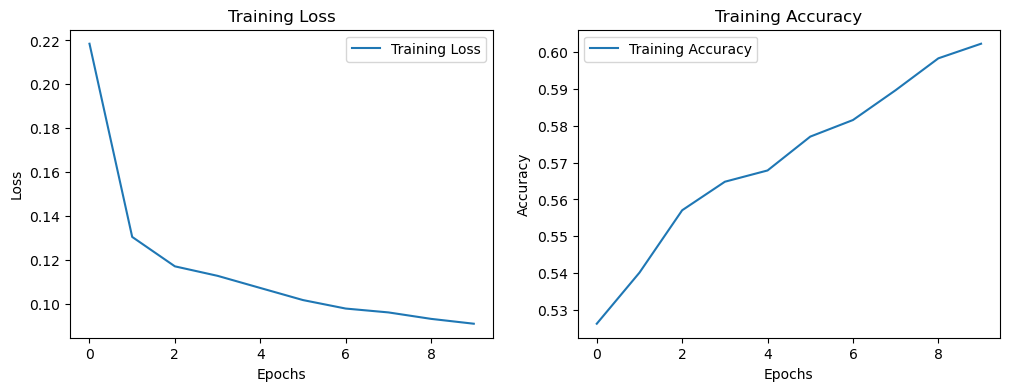

In [24]:
import matplotlib.pyplot as plt

# Plotting model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Visualisasi loss dan akurasi
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Menampilkan hasil pelatihan
plot_training_history(history)


### Cell 8: Memuat Model dan Tokenizer, dan Fungsi untuk Menghasilkan Output

In [26]:
# Memuat model yang telah disimpan
model = tf.keras.models.load_model('saved_model/saved_notebook_02/generative_model.h5')

# Memuat tokenizer
with open('./saved_notebook_02/tokenizer_texts.pkl', 'rb') as file:
    tokenizer_texts = pickle.load(file)

with open('./saved_notebook_02/tokenizer_codes.pkl', 'rb') as file:
    tokenizer_codes = pickle.load(file)

# Fungsi untuk menghasilkan kode dari input teks
def generate_code(input_text):
    input_seq = tokenizer_texts.texts_to_sequences([input_text])
    padded_input = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=100, padding='post')

    # Menggunakan model untuk memprediksi output
    predicted_seq = model.predict([padded_input, padded_input])
    
    # Mengkonversi output menjadi kode
    generated_code = tokenizer_codes.sequences_to_texts(predicted_seq.argmax(axis=-1))
    return generated_code[0]

# Fungsi untuk menerima input dan menghasilkan output
def interactive_code_generation():
    while True:
        user_input = input("Masukkan perintah atau 'exit' untuk keluar: ")
        if user_input.lower() == 'exit':
            break
        generated_code = generate_code(user_input)
        print(f"Kode yang dihasilkan:\n{generated_code}")

# Memulai interaksi
interactive_code_generation()


Kode yang dihasilkan:
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Kode yang dihasilkan:
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Kode yang dihasilkan:
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
